In [508]:
import os
import csv
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 1000)
plt.style.use('ggplot') 
import warnings
warnings.filterwarnings('ignore')

import talib as ta
from talib import abstract
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector, Input
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb
import xgboost as xgb

# Read Data

In [2]:
for _, _, filename in os.walk("/input/ctbcsec-interview"):
    print(filename)

['CorpInfo_2014.csv', 'ETFInfo_2019.csv', 'Off_Corp_2014.csv', 'Test_X.csv', 'Test_Y.csv', 'Train_X.csv', 'Train_Y.csv']


In [720]:
def read_csv():
    BASE_PATH = "/input/ctbcsec-interview/"
    print("Reading Train_X.csv as dataframe...")
    train_X = pd.read_csv(BASE_PATH + "Train_X.csv", encoding='cp950')
    print("Completed! train_X have {} columns, {} rows".format(train_X.shape[0], train_X.shape[1]))

    print("Reading Train_Y.csv as dataframe...")
    train_y = pd.read_csv(BASE_PATH + "Train_Y.csv", encoding='cp950')
    print("Completed! train_y have {} columns, {} rows".format(train_y.shape[0], train_y.shape[1]))

    print("Reading Test_X.csv as dataframe...")
    test_X = pd.read_csv(BASE_PATH + "Test_X.csv", encoding='cp950')
    print("Completed! test_X have {} columns, {} rows".format(test_X.shape[0], test_X.shape[1]))

    print("Reading Test_Y.csv as dataframe...")
    test_y = pd.read_csv(BASE_PATH + "Test_Y.csv", encoding='cp950')
    print("Completed! test_y have {} columns, {} rows".format(test_y.shape[0], test_y.shape[1]))

    print("Reading CorpInfo_2014.csv as dataframe...")
    corp_info = pd.read_csv(BASE_PATH + "CorpInfo_2014.csv", engine='python')
    print("Completed! corp_info have {} columns, {} rows".format(corp_info.shape[0], corp_info.shape[1]))

    print("Reading ETFInfo_2019.csv as dataframe...")
    etf_info = pd.read_csv(BASE_PATH + "ETFInfo_2019.csv", engine='python')
    print("Completed! etf_info have {} columns, {} rows".format(etf_info.shape[0], etf_info.shape[1]))

    print("Reading Off_Corp_2014.csv as dataframe...")
    off_corp = pd.read_csv(BASE_PATH + "Off_Corp_2014.csv", engine='python')
    print("Completed! off_corp have {} columns, {} rows".format(off_corp.shape[0], off_corp.shape[1]))
    
    return train_X, train_y, test_X, test_y, corp_info, etf_info, off_corp

In [5]:
#modify specific columns label for Ta-Lib
def label_rename(*dfs):
    def toid(df):
        df.rename(columns={'股票代號': 'id'}, inplace=True)
    for d in dfs:
        toid(d)
    all_data_X.rename(columns={'開盤價': 'open', '收盤價': 'close', '最高價': 'high', '最低價': 'low', '成交量': 'volume', '成交量變動...': 'volume_change'}, inplace=True)
    print('Renamed the label of columns.')

In [ ]:
def to_dateframe(*dfs):
    for df in dfs:
        df.rename(columns={'日期': 'date'}, inplace=True)
        df['dateframe'] = pd.to_datetime(df['date'], format='%Y%m%d')
        df['month'] = df['dateframe'].dt.month
        df['dayofweek'] = df['dateframe'].dt.dayofweek
        df['weekofyear'] = df['dateframe'].dt.weekofyear
        df['quarter'] = df['dateframe'].dt.quarter
    print('Completed date transform!')

In [ ]:
def stock_categorical():
    corp_info.id = corp_info.id.astype('str')
    off_corp.id = off_corp.id.astype('str')
    corp_info.rename(columns={'指數彙編分類代號': 'cate_id'}, inplace=True)
    etf_info.rename(columns={'ETF類型代號': 'cate_id'}, inplace=True)
    etf_info['cate_id'] = etf_info['cate_id'].apply(lambda x: 'ETF_' + x)
    all_data_X = all_data_X.merge(corp_info[['id', '產業名稱', 'cate_id']], on=['id'], how='left')
    all_data_X.update(etf_info[['id', 'cate_id']], join='left', inplace=True)

In [6]:
train_X, train_y, test_X, test_y, corp_info, etf_info, off_corp = read_csv() #讀取CSV
all_data_X = pd.concat([train_X, test_X]) #合併Train & Test以利後續處理

label_rename(all_data_X, off_corp, corp_info, etf_info) #修改columns label
to_dateframe(all_data_X, train_y, test_X, test_y) #將日期轉為dateframe格式

all_data_X.sort_values('date').reset_index(drop=True, inplace=True)

stock_id_list = list(corp_info.id) + list(off_corp.id) + ['2002A', '2833A'] #特別股
etf_id_list = list(etf_info.id)

Renamed the label of columns.


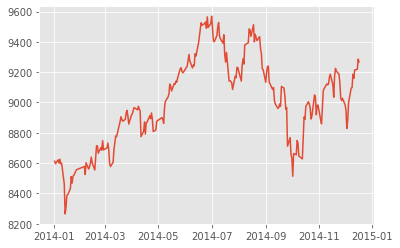

In [11]:
plt.plot(train_y.dateframe, train_y.Target_Y)
plt.show()

In [721]:
train_X.head(3)

,日期,股票代號,股票名稱,開盤價,最高價,最低價,收盤價,漲跌,漲幅...,振幅...,成交量,成交筆數,成交金額.千.,均張,成交量變動...,均張變動...,股本.百萬.,總市值.億.,市值比重...,本益比,股價淨值比,本益比.近四季.,週轉率...,成交值比重...,漲跌停,均價,成交量.股.,RTIME
0,20140127,0015,富邦,9.07,9.08,9.04,9.04,-0.15,-1.63,0.44,265.0,31.0,2401.0,8.5,-86.79,-80.09,5000.0,45.2,0.019,NaN,NaN,NaN,0.05,0.002,0.0,9.06,265000.0,123459.0
1,20140127,0050,台灣50,58.10,58.20,57.45,57.60,-1.05,-1.79,1.28,21325.0,5733.0,1228050.0,3.7,99.19,-51.32,13495.0,777.3,NaN,NaN,NaN,NaN,1.58,1.223,0.0,57.59,21325343.0,123459.0
2,20140127,0051,中100,29.46,29.67,29.35,29.50,-0.32,-1.07,1.07,35.0,31.0,1048.0,1.1,-38.60,-26.67,205.0,6.0,NaN,NaN,NaN,NaN,0.17,0.001,0.0,29.53,35500.0,123459.0


In [36]:
all_data_X.describe()

,date,open,high,low,close,漲跌,漲幅...,振幅...,volume,成交筆數,成交金額.千.,均張,volume_change,均張變動...,股本.百萬.,總市值.億.,市值比重...,本益比,股價淨值比,本益比.近四季.,週轉率...,成交值比重...,漲跌停,均價,成交量.股.,RTIME,month,dayofweek,weekofyear,quarter
count,4.230080e+05,408700.000000,408700.000000,408700.000000,420785.000000,423008.000000,423008.000000,408795.000000,4.117180e+05,4.094950e+05,4.094950e+05,402245.000000,4.000510e+05,3.980520e+05,4.039010e+05,403654.000000,384559.000000,330515.000000,395747.000000,286927.000000,403645.000000,397514.000000,390231.000000,422761.000000,4.117170e+05,407227.000000,423008.000000,423008.000000,423008.000000,423008.000000
mean,2.014069e+07,135.642971,136.519154,134.649320,201.779038,0.056596,0.049258,2.381460,1.262176e+04,3.720957e+03,4.534028e+05,2.488413,5.679936e+01,1.840059e+01,3.002132e+04,1277.676016,0.777237,29.140811,1.998936,55.410522,0.666338,0.567765,0.016703,152.669282,1.262204e+07,123458.979540,6.734880,2.004312,27.480251,2.574353
std,3.419962e+02,867.307802,870.290813,863.590733,1184.315999,8.860074,2.090600,1.814779,1.511022e+05,3.454767e+04,4.218536e+06,57.297275,4.649922e+03,5.754766e+03,2.856631e+05,12367.130477,5.906366,72.629690,2.065239,565.107245,1.291239,4.246726,0.176504,1003.670390,1.511026e+08,1.951766,3.418577,1.418953,14.938599,1.108782
min,2.014010e+07,1.150000,1.160000,1.120000,1.150000,-413.960000,-18.490000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-1.000000e+02,-1.000000e+02,5.000000e-01,0.400000,0.001000,0.800000,0.000000,0.000000,0.000000,0.000000,-1.000000,1.140000,0.000000e+00,122222.000000,1.000000,0.000000,1.000000,1.000000
25%,2.014041e+07,14.600000,14.797500,14.450000,14.850000,-0.250000,-0.860000,1.130000,1.070000e+02,5.700000e+01,2.227000e+03,1.500000,-3.651000e+01,-1.333000e+01,6.470000e+02,15.100000,0.020000,12.400000,1.030000,13.200000,0.090000,0.005000,0.000000,14.840000,1.070740e+05,123459.000000,4.000000,1.000000,15.000000,2.000000
50%,2.014071e+07,26.400000,26.750000,26.100000,27.350000,0.000000,0.000000,1.900000,4.070000e+02,2.000000e+02,1.102100e+04,1.900000,-4.010000e+00,0.000000e+00,1.223000e+03,38.400000,0.046000,16.600000,1.460000,18.000000,0.250000,0.022000,0.000000,26.870000,4.076310e+05,123459.000000,7.000000,2.000000,28.000000,3.000000
75%,2.014101e+07,51.400000,52.000000,50.700000,55.800000,0.200000,0.760000,3.130000,1.584000e+03,7.150000e+02,5.559950e+04,2.700000,4.992000e+01,1.500000e+01,3.337000e+03,106.200000,0.118000,25.900000,2.250000,28.900000,0.680000,0.101000,0.000000,51.060000,1.583845e+06,123459.000000,10.000000,3.000000,40.000000,4.000000
max,2.014123e+07,13899.740000,13902.140000,13810.400000,18274.940000,325.580000,78.040000,61.820000,7.812593e+06,1.273329e+06,1.537923e+08,36265.500000,2.901140e+06,3.626450e+06,6.955320e+06,275392.000000,100.000000,2984.800000,66.380000,39937.500000,76.300000,93.580000,1.000000,18274.940000,7.812593e+09,123459.000000,12.000000,5.000000,52.000000,4.000000


In [13]:
train_y['Target_Y'].describe()

count     237.000000
mean     9009.377384
std       293.439287
min      8264.480000
25%      8808.610000
50%      8999.520000
75%      9223.180000
max      9569.170000
Name: Target_Y, dtype: float64

In [15]:
stock_df = all_data_X[all_data_X.id.isin(stock_id_list)]
stock_df.isnull().sum()

date                 0
id                   0
股票名稱                 0
open                 0
high                 0
low                  0
close                0
漲跌                   0
漲幅...                0
振幅...                0
volume               0
成交筆數                 0
成交金額.千.              0
均張                3805
volume_change     7367
均張變動...           7395
股本.百萬.             493
總市值.億.             740
市值比重...          12773
本益比              66541
股價淨值比             1563
本益比.近四季.         93608
週轉率...             740
成交值比重...          6631
漲跌停                  0
均價                   0
成交量.股.               0
RTIME             2316
產業名稱              1531
cate_id           1778
dateframe            0
month                0
dayofweek            0
weekofyear           0
quarter              0
dtype: int64

# Build Regressor Model API

In [16]:
class Base_Model(object):
    def __init__(self, train, test, features, n_fold=5):
        self.train = train
        self.test = test
        self.features = features
        self.target = 'close_T+10'
        self.n_fold = n_fold
        self.params = self.get_params()
        self.y_pred, self.oof_pred, self.models = self.fit()
        
    def get_params(self):
        raise NotImplementError
    
    def fit(self):
        models = []
        y_pred = np.zeros((self.test.shape[0],))
        oof_pred = np.zeros((self.train.shape[0]))
        kf = KFold(n_splits=self.n_fold, random_state=2019, shuffle=True)
        for i, (train_idx, val_idx) in enumerate(kf.split(self.train, self.train[self.target])):
            X_train, y_train = self.train[self.features].iloc[train_idx], self.train[self.target].iloc[train_idx]
            X_val, y_val = self.train[self.features].iloc[val_idx], self.train[self.target].iloc[val_idx]
            model = self.train_model(X_train, y_train, X_val, y_val)
            oof_pred[val_idx] = model.predict(X_val).reshape(oof_pred[val_idx].shape)
            y_pred += model.predict(self.test[self.features]).reshape(y_pred.shape) / self.n_fold
            print('Fold {} score is {}'.format(i+1, np.sqrt(mean_squared_error(y_val, oof_pred[val_idx]))))
            models.append(model)
        score = np.sqrt(mean_squared_error(self.train[self.target], oof_pred))
        print(f'oof scores is {score}')
            
        return y_pred, oof_pred, models

In [17]:
class LGB_regr(Base_Model):
    def train_model(self, X_train, y_train, X_val, y_val):
        model = lgb.LGBMRegressor(**self.params)
        return model.fit(X=X_train, y=y_train,
                         eval_set=[(X_train, y_train), (X_val, y_val)],
                         #eval_metric=eval_qwk_lgb_regr,
                         verbose=0,
                         early_stopping_rounds=self.params['early_stopping_rounds'])
    def get_params(self):
        params = {'n_estimators': 5000,
                  'boostin_type': 'gdbt',
                  'objective': 'regression',
                  'metric': 'rmse',
                  'subsample': 0.75,
                  'subsample': 1,
                  'learning': 0.015,
                  'feature_fraction': 0.9,
                  'max_depth': 15,
                  'lambda_l1': 1,
                  'lambda_l2': 1,
                  #'verbose': 500,
                  'early_stopping_rounds': 100,
                  'eval_metric': 'cappa',
                  'random_seed': 46
                 }
        return params

In [250]:
class XGB_regr(Base_Model):
    def train_model(self, X_train, y_train, X_val, y_val):
        model = xgb.XGBRegressor(**self.params)
        return model.fit(X=X_train, y=y_train,
                         eval_set=[(X_train, y_train), (X_val, y_val)],
                         #eval_metric=eval_qwk_xgb_regr,
                         verbose=0,
                         early_stopping_rounds=self.params['early_stopping_rounds'])
    
    def get_params(self):
        params = {'colsample_bytree': 0.4603,
                  'gamma': 0.0468, 
                  'learning_rate': 0.01,
                  'max_depth': 5, 
                  'min_child_weight': 1.7817,
                  'n_estimators': 2200,
                  'reg_alpha': 0.4640,
                  'reg_lambda': 0.8571,
                  'subsample': 0.5213,
                  'objective':'reg:squarederror',
                  'silent': 1,
                  'random_state': 46,
                  'nthread': -1,
                  #'eval_metric': 'eval_qwk_xgb_regr',
                  #'disable_default_eval_metric': 1,
                  'early_stopping_rounds': 100,
                  }
        return params

# Data Enconder

In [252]:
def data_encoder(train, target):
    data = []
    vol_keeper = 0
    updown_count = {'up': 0, 'down': 0}
    adxr_raise = np.zeros((target.shape[0] + 10))
    adxr_down = np.zeros((target.shape[0] + 10))
    
    #個股表現
    for i, (sid, bystock) in enumerate(train[train.id.isin(stock_id_list)].groupby('id', sort=False)):
        if bystock.shape[0] == 247 and i > 16:
            
            #adxr: 搭配di預測漲跌個股數量
            adxr = abstract.ADXR(bystock).reset_index(drop=True)
            adx = abstract.ADX(bystock).reset_index(drop=True)
            minus_di = abstract.MINUS_DI(bystock).reset_index(drop=True)
            plus_di = abstract.PLUS_DI(bystock).reset_index(drop=True)
            adxr_raise += (plus_di > minus_di) & (adx > adxr)
            adxr_down += (plus_di < minus_di) & (adx > adxr)
   
            #CCI
            #cci = abstract.CCI(df)
            #willr = abstract.WILLR(df)
    
    #
    for i, (d, df) in enumerate(train.groupby('date', sort=False)):
        
        stock_df = df[df.id.isin(stock_id_list)]
        etf_df = df[df.id.isin(etf_id_list)]
        index_df = df[(df.id.str.contains('TW')) | (df.id.str.startswith('R'))]

        date = df.date.iloc[0]
        datestamp = df.dateframe.iloc[0]
        month = df.month.iloc[0]
        dayofweek = df.dayofweek.iloc[0]
        weekofyear = df.weekofyear.iloc[0]
        quarter = df.quarter.iloc[0]
        
        T10_close = target.Target_Y.iloc[i] if i < target.shape[0] else 0
        close = target.Target_Y[i-10] if i >= 10 else 0 
        raise_rate = (target.Target_Y[i-1]/close) - 1 if i != 0 and i < 237 else 0
        vol = stock_df.volume.sum()
        vol_diff = vol / vol_keeper - 1 if vol_keeper != 0 else 0
        vol_keeper = vol
        
        #cate transform
        cate_vol = stock_df.pivot_table(index='date', columns='cate_id', values='volume', aggfunc=np.sum)
        
        features = updown_count.copy()
        features['date'] = date
        features['datestamp'] = datestamp
        features['month'] = month
        features['dayofweek'] = dayofweek
        features['weekofyear'] = weekofyear
        features['quarter'] = quarter
        features['volume'] = vol
        features['volume_diff'] = vol_diff
        features['close'] = close
        features['close_T+10'] = T10_close
        #features['raise_rate'] = raise_rate
        
        data.append(features)
            
    #大盤指標 by ta-lib functions
    data_df = pd.DataFrame(data).reset_index()
    single = ['SMA','EMA','WMA','TRIMA','KAMA','T3',
              'HT_DCPERIOD', 'HT_TRENDMODE',
              'APO', 'CMO', 'MOM', 'PPO', 'ROC', 'ROCR', 'ROCR100', 'RSI',
              'STDDEV', 'TSF', 'VAR']
    
    for f in single:
        try:
            output = eval('ta.' + f + '(data_df.close)')
            output.name = f.lower() if type(output) == pd.core.series.Series else None
            data_df = pd.merge(data_df, pd.DataFrame(output), left_on = data_df.index, right_on = output.index)
            data_df = data_df.set_index('key_0')
        except:
            print(f)
    
    
    upband, midband, lowerband = ta.BBANDS(data_df.close)
    data_df['BB_mid'] = midband
    data_df['BB_locate'] = data_df['close'] - data_df['BB_mid']
    data_df['BB_width'] = upband - lowerband
    
    data_df['adxr_raise'] = adxr_raise
    data_df['adxr_down'] = adxr_down
    
    data_df.set_index('index', drop=True, inplace=True)
    #data_df = pd.merge(data_df, pd.DataFrame(output), left_on = data_df.index, right_on = output.index)    
    
    return data_df

In [253]:
#合併前五日特徵
def merge_Tminus_days(df, minus_tday=5):
    shift_df = df.copy()
    for i in range(minus_tday):
        df = df.merge(shift_df.shift(i+1), left_on=df.index, right_on=shift_df.index, suffixes=['_'+str(i), '_'+str(i+1)])
        df = df.drop(columns=['key_0'])
    return df

In [254]:
ec_all_data = data_encoder(all_data_X, train_y)

In [256]:
y = ec_all_data['close_T+10']
data_timestamp = ec_all_data['datestamp']
ec_all_data = ec_all_data.drop(columns=['date', 'datestamp', 'close_T+10'])

In [56]:
ec_merged = merge_Tminus_days(ec_all_data)

In [57]:
ec_test = ec_merged.tail(10).reset_index()
ec_train = ec_merged.iloc[30: -10].reset_index()

In [27]:
#features = ec_all_data.loc[(ec_all_data.sum(axis=1) != 0), (ec_all_data.sum(axis=0) != 0)].columns
features = ec_all_data.columns

In [28]:
#標準化
sc = StandardScaler() 
train_scaled = pd.DataFrame(sc.fit_transform(ec_train[features]), columns=features)
test_scaled = pd.DataFrame(sc.transform(ec_test[features]), columns=features)

In [29]:
train_scaled['close_T+10'] = y[30:-10].reset_index(drop=True)
test_scaled['close_T+10'] = y[-10:].reset_index(drop=True)

# Train Model

In [30]:
lgb_regr = LGB_regr(train_scaled, test_scaled, features, n_fold=5)

Fold 1 score is 64.14543490072339
Fold 2 score is 100.01025021021815
Fold 3 score is 78.57945262725849
Fold 4 score is 81.02871610863292
Fold 5 score is 59.623765518900136
oof scores is 78.05025304704974


In [31]:
xgb_regr = XGB_regr(train_scaled, test_scaled, features, n_fold=5)

Fold 1 score is 67.38293277170874
Fold 2 score is 77.5183061468555
Fold 3 score is 71.33363309302702
Fold 4 score is 73.63124689762189
Fold 5 score is 68.10325880436055
oof scores is 71.69962695662916


In [32]:
lgb_oof_pred = lgb_regr.oof_pred
lgb_y_pred = lgb_regr.y_pred
xgb_oof_pred = xgb_regr.oof_pred
xgb_y_pred = xgb_regr.y_pred

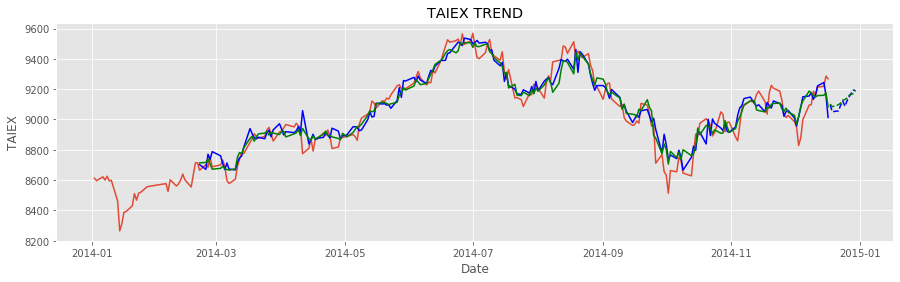

In [747]:
plt.figure(figsize=(15, 4))
plt.plot(data_timestamp[:-10], train_y.Target_Y)
plt.plot(train_y.iloc[30:].dateframe, lgb_oof_pred, 'b')
plt.plot(test_y.dateframe, lgb_y_pred, 'b--')
plt.plot(train_y.iloc[30:].dateframe, xgb_oof_pred, 'g')
plt.plot(test_y.dateframe, xgb_y_pred, 'g--')

plt.title("TAIEX TREND")
#plt.legend(('Actual', 'Train predict', 'Test predict'), loc='best', framealpha=0.5)
plt.xlabel('Date')
plt.ylabel('TAIEX')
plt.show()

In [694]:
feature_importance = list(zip(features, list(lgb_regr.models[0].feature_importances_)))
dt = pd.DataFrame(feature_importance,  columns=['feature' ,'importance'])
dt.sort_values(by=['importance'], ascending=False).head(10)

,feature,importance
7,volume_diff_0,125
161,BB_locate_4,123
73,volume_diff_2,117
29,BB_locate_0,110
40,volume_diff_1,105
106,volume_diff_3,102
180,ht_dcperiod_5,95
147,ht_dcperiod_4,87
172,volume_diff_5,80
105,volume_3,79


# LSTM

In [695]:
def train_windows(df, y, ref_day=10, predict_day=10):
    X_train, Y_train = [], []
    for i in range(df.shape[0] - ref_day + 1):
        X_train.append(np.array(df.iloc[i: i + ref_day]))
        Y_train.append(np.array(y.iloc[i: i + ref_day]))
    return np.array(X_train), np.array(Y_train)

In [696]:
def lstm_stock_model(shape):
    model = Sequential()
    model.add(LSTM(33, input_shape=(shape[1], shape[2]), return_sequences=True)) 
    model.add(LSTM(33, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    
    adam = tf.keras.optimizers.Adam(lr=0.0001)
    model.compile(loss='mae',
                  optimizer=adam,
                  metrics=['mean_absolute_error'])

    model.summary()
    return model

In [697]:
sc = StandardScaler() 
train_scaled = pd.DataFrame(sc.fit_transform(ec_all_data), columns=ec_all_data.columns)
y_scaled = pd.DataFrame(sc.fit_transform(pd.DataFrame(y)), columns={'y'})['y']

In [698]:
all_x, all_y = train_windows(train_scaled.iloc[32:], y_scaled.iloc[32:])
all_y = all_y[:,:,np.newaxis]

In [699]:
lstm_train_X, lstm_train_y = all_x[:-10,:,:], all_y[:-10,:,:]
lstm_test_X, lstm_test_y = all_x[-10:,:,:], all_y[-10:,:,:]

In [700]:
print(lstm_train_X.shape, lstm_train_y.shape)

(196, 10, 33)

In [702]:
model = lstm_stock_model(lstm_train_X.shape)
callback = EarlyStopping(monitor="val_loss", patience=14, verbose=1, mode="auto")
checkpoints = ModelCheckpoint('10_days_lstm_v2.h5', save_best_only=True)
lr_function = ReduceLROnPlateau(monitor='val_loss', patience=7, verbose=1, factor=0.2, min_lr=0.00001)

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_81 (LSTM)               (None, 10, 33)            8844      
_________________________________________________________________
lstm_82 (LSTM)               (None, 10, 33)            8844      
_________________________________________________________________
time_distributed_50 (TimeDis (None, 10, 1)             34        
Total params: 17,722
Trainable params: 17,722
Non-trainable params: 0
_________________________________________________________________


In [703]:
history = model.fit(lstm_train_X, lstm_train_y,
                    epochs=2000,
                    batch_size=4,
                    validation_split=0.1,
                    callbacks=[callback, checkpoints, lr_function],
                    verbose=1,
                    shuffle=True)

Train on 176 samples, validate on 20 samples
Epoch 1/2000
176/176 [==============================] - 2s 10ms/sample - loss: 0.1798 - mean_absolute_error: 0.1798 - val_loss: 0.2135 - val_mean_absolute_error: 0.2135
Epoch 2/2000
176/176 [==============================] - 0s 2ms/sample - loss: 0.1277 - mean_absolute_error: 0.1277 - val_loss: 0.1927 - val_mean_absolute_error: 0.1927
Epoch 3/2000
176/176 [==============================] - 0s 3ms/sample - loss: 0.1088 - mean_absolute_error: 0.1088 - val_loss: 0.1813 - val_mean_absolute_error: 0.1813
Epoch 4/2000
176/176 [==============================] - 0s 3ms/sample - loss: 0.1001 - mean_absolute_error: 0.1001 - val_loss: 0.1759 - val_mean_absolute_error: 0.1759
Epoch 5/2000
176/176 [==============================] - 0s 3ms/sample - loss: 0.0941 - mean_absolute_error: 0.0941 - val_loss: 0.1700 - val_mean_absolute_error: 0.1700
Epoch 6/2000
176/176 [==============================] - 0s 3ms/sample - loss: 0.0889 - mean_absolute_error: 0.0889

176/176 [==============================] - 0s 2ms/sample - loss: 0.0324 - mean_absolute_error: 0.0324 - val_loss: 0.0853 - val_mean_absolute_error: 0.0853
Epoch 50/2000
176/176 [==============================] - 0s 3ms/sample - loss: 0.0321 - mean_absolute_error: 0.0321 - val_loss: 0.0836 - val_mean_absolute_error: 0.0836
Epoch 51/2000
176/176 [==============================] - 0s 2ms/sample - loss: 0.0317 - mean_absolute_error: 0.0317 - val_loss: 0.0835 - val_mean_absolute_error: 0.0835
Epoch 52/2000
176/176 [==============================] - 0s 2ms/sample - loss: 0.0313 - mean_absolute_error: 0.0313 - val_loss: 0.0840 - val_mean_absolute_error: 0.0840
Epoch 53/2000
176/176 [==============================] - 0s 2ms/sample - loss: 0.0308 - mean_absolute_error: 0.0308 - val_loss: 0.0843 - val_mean_absolute_error: 0.0843
Epoch 54/2000
176/176 [==============================] - 0s 3ms/sample - loss: 0.0305 - mean_absolute_error: 0.0305 - val_loss: 0.0829 - val_mean_absolute_error: 0.0829


<Figure size 1440x1008 with 0 Axes>

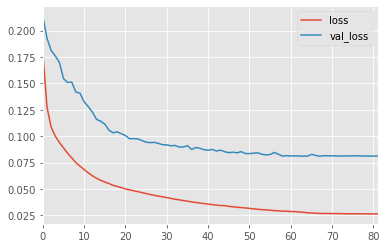

In [704]:
plt.figure(figsize=(20, 14))
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
plt.show()

In [724]:
test_pred = sc.inverse_transform(model.predict(lstm_test_X))[:,-1,:]

In [725]:
lstm_oof_pred = sc.inverse_transform(model.predict(lstm_train_X))[:,-1,:]

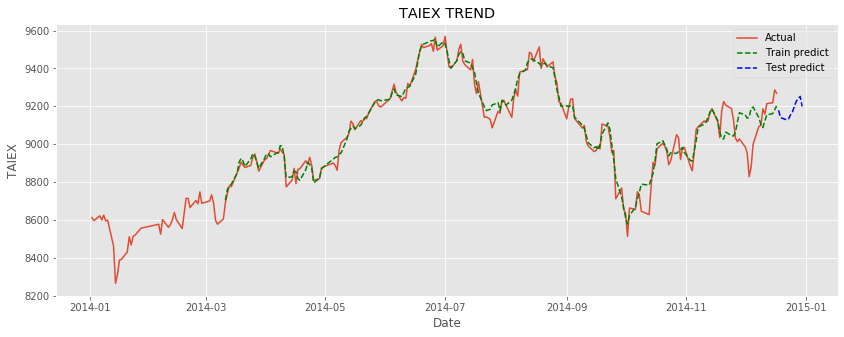

In [744]:
plt.figure(figsize=(14, 5))
plt.plot(data_timestamp[:-10], train_y.Target_Y, '')
plt.plot(train_y.iloc[41:].dateframe, lstm_oof_pred, 'g--')
plt.plot(test_y.dateframe, test_pred, 'b--')

plt.title("TAIEX TREND")
plt.legend(('Actual', 'Train predict', 'Test predict'), loc='best', framealpha=0.5)
plt.xlabel('Date')
plt.ylabel('TAIEX')
plt.show()